# EpiEstim

EpiEstim assumes that $R_t$ is fixed over trailing windows of length
$k$. This notebook:

-   Demonstrates how to fit EpiEstim with a fixed value of $k$
-   How to find the posterior distribution of $k$
-   How to marginalise out $k$ to present robust estimates of $R_t$
-   How to find the predictive distribution for reported cases
-   How to calculate predictive coverage and scoring rule values

All code can be found in the `/src/` folder of the [GitHub
repository](https://github.com/nicsteyn2/RobustRtEstimators). We
recommend cloning this repository and then opening `EpiEstim.ipynb` in
your preferred Jupyter notebook environment.

## Setting up

First, we need to load the necessary source code and data. We will use
data from the 2021 August outbreak of SARS-CoV-2 in Aotearoa New
Zealand. The serial interval is assumed to be gamma-distributed with
mean 6.5 days and standard deviation 4.2 days (Parag, Cowling, and
Donnelly 2021; Ferguson et al. 2020).

In [1]:
using Plots, Measures # Load package for plotting

# Ensure we are working in the root directory
# You may need to edit this for your own machine
const rootdir = @__DIR__
cd(joinpath(rootdir, ".."))

# Load source files
include("src/EpiEstim.jl")
include("src/support.jl")

# Load data
(Ct, w) = loadData("NZCOVID_AUG2021")
dates = Date("2021-08-17") .+ Day.(0:181)

# Plot
bar(dates, Ct, size=(800,400), label=false, ylabel="Reported cases", xlabel="Date", title="NZ COVID-19 cases (local transmission only)", margins=3mm, color="#f25a2a")

## Fitting default EpiEstim

We can fit the default EpiEstim model (with $k = 7$) using the
`EpiEstim(k, w, Ct)` function:

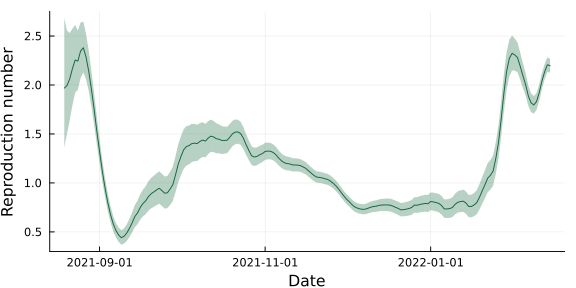

In [2]:
# Fit the model
pRt = EpiEstim(7, w, Ct)

# Extract mean and 95% credible interval
(m, l, u) = (mean.(pRt), quantile.(pRt, 0.025), quantile.(pRt, 0.975))

# Plot output
plotR = plot(dates[3:end], m[3:end], ribbon=(m[3:end]-l[3:end], u[3:end]-m[3:end]), fillalpha=0.3, label=false, ylabel="Reproduction number", xlabel="Date", size=(600,300), color="#13643f")

## Likelihood and posterior distribution for $k$

We can calculate the likelihood on a range of $k$ values:

In [3]:
kvals = collect(1:30) # We will consider k = 1, 2, ..., 30
(loglik, _) = EpiEstimLogLik(kvals, w, Ct; windin=3)
bar(kvals, loglik[:,end], label=false, ylabel="Log-likelihood", xlabel="k", size=(600,300))

By assuming a uniform prior distribution for $k$ and normalising, we can
calculate the posterior distribution of $k$ given our observed data:

In [4]:
pK = exp.(loglik .- maximum(loglik, dims=1)) # Apply Bayes' theorem
pK = pK ./ sum(pK, dims=1) # Normalise
bar(kvals, pK[:,end], label=false, ylabel="Posterior probability", xlabel="k", size=(600,300))

In this case it is clear that $k = 2$ is the most likely value given the
data. We could just run EpiEstim at $k = 2$, but let’s be more thorough
and use the full marginal posterior estimator.

## Marginal posterior distribution for $R_t$

To find the marginal posterior distribution for $R_t$, we need to
specify a grid of $R_t$ values to average over. We can then use the
`EpiEstimMarginalPosterior()` function to calculate the marginal
posterior distribution of $R_t$.

In [5]:
Rgrid = LinRange(0.01, 10, 1000)
pR = EpiEstimMarginalPosterior(w, Ct, Rgrid; windin=3)
(m, med, l, u) = calculateResults(pR, Rgrid)
plot!(plotR, dates[4:end], m[4:end], ribbon=(m[4:end]-l[4:end], u[4:end]-m[4:end]), fillalpha=0.3, ylabel="Reproduction number", xlabel="Date", size=(600,300), label="Marginalised estimates")

## Predictive distributions

We can also estimate the default and marginalised predictive
distributions for reported cases. We also calculate predictive coverages
as we go (reported in the next section).

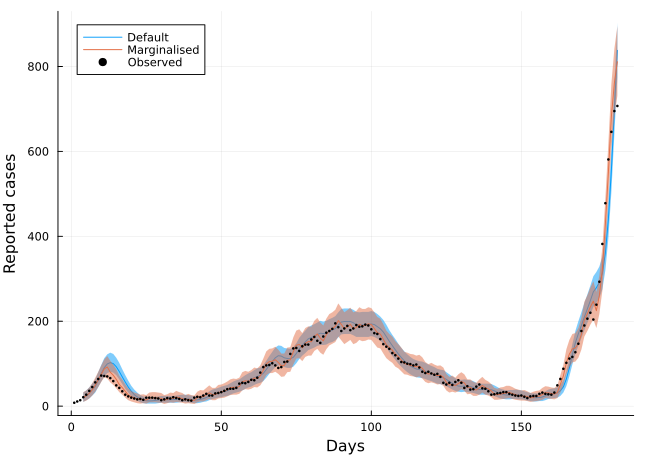

In [6]:
# Default
pCdefault = EpiEstimConditionalPredictive(7, w, Ct)
(m, med, l, u) = calculateResults(pCdefault)
default_coverage = mean((l[4:end] .<= Ct[4:end]) .& (Ct[4:end] .<= u[4:end]))
plotCases = plot(4:length(m), m[4:end], ribbon=(m[4:end]-l[4:end], u[4:end]-m[4:end]), label="Default", ylabel="Reported cases", xlabel="Days")

# Marginalised
Cgrid = 0:(10*maximum(Ct))
pC = EpiEstimMarginalPredictive(w, Ct, Cgrid, windin=3)
(m, med, l, u) = calculateResults(pC, Cgrid)
marginalised_coverage = mean((l[4:end] .<= Ct[4:end]) .& (Ct[4:end] .<= u[4:end]))
plot!(plotCases, 4:length(m), m[4:end], ribbon=(m[4:end]-l[4:end], u[4:end]-m[4:end]), label="Marginalised")

# Also show the observed data
scatter!(plotCases, 1:length(Ct), Ct, label="Observed", color=:black, markersize=1.5)

## Predictive coverage and scoring rules

Calculating predictive coverage:

In [7]:
println("Predictive coverage of default EpiEstim = $(round(100*default_coverage))%")
println("Predictive coverage of marginalised EpiEstim = $(round(100*marginalised_coverage))%")

Predictive coverage of default EpiEstim = 87.0%
Predictive coverage of marginalised EpiEstim = 99.0%

and the **CRPS** (lower is better) for each model:

In [8]:
include("src/scoringRules.jl")
default_crps = CRPS(pCdefault, Ct, windin=3)
marginalised_crps = CRPS(cumsum(pC, dims=1), Cgrid, Ct, windin=3)

println("CRPS of default EpiEstim = $(default_crps)")
println("CRPS of marginalised EpiEstim = $(marginalised_crps)")

CRPS of default EpiEstim = 9.748611012811024
CRPS of marginalised EpiEstim = 5.577113951260321

Ferguson, N, D Laydon, G Nedjati Gilani, N Imai, K Ainslie, M Baguelin,
S Bhatia, et al. 2020. “Report 9: Impact of Non-Pharmaceutical
Interventions (NPIs) to Reduce COVID19 Mortality and Healthcare Demand.”
Imperial College London. <https://doi.org/10.25561/77482>.

Parag, Kris V., Benjamin J. Cowling, and Christl A. Donnelly. 2021.
“Deciphering Early-Warning Signals of SARS-CoV-2 Elimination and
Resurgence from Limited Data at Multiple Scales.” *Journal of The Royal
Society Interface* 18 (185): 20210569.
<https://doi.org/10.1098/rsif.2021.0569>.